In [1]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.set_random_seed(683)
# Uncomment this to hide TF warnings about allocation
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [3]:
#Load the data.
train = pd.read_json("data/processed/train.json")
test = pd.read_json("data/processed/test.json")

In [14]:
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [15]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [16]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


In [5]:
from scipy.ndimage import rotate as rot

def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    image_rotate = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
        #rotate 
        band_1_rotate = rot(band_1, 30, reshape=False)
        band_2_rotate = rot(band_2, 30, reshape=False)
        band_3_rotate = rot(band_3, 30, reshape=False)
        image_rotate.append(np.dstack((band_1_rotate, band_2_rotate, band_3_rotate)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    rotated = np.array(image_rotate)
    images = np.concatenate((images, mirrorlr, mirrorud, rotated))
    return images

In [17]:
X_images = augment(X_images)
y_train = np.concatenate((y_train,y_train, y_train, y_train))

print (X_images.shape)
print (y_train.shape)

(6416, 75, 75, 3)
(6416,)


In [18]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_images, y_train, random_state=1, train_size=0.75)

E:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.5,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
#gen_train_flow = gen_flow(X_train_cv, y_train_cv)
#gen_valid_flow = gen_flow(X_valid, y_valid)

In [8]:
#Import Keras.
from matplotlib import pyplot
import keras as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [7]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel



### FCN

In [9]:
def ConvBlock(model, layers, filters):
    '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

def create_model():
    '''Create the FCN and return a keras model.'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    #model.add(Activation('softmax'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    model.summary()
    return model

In [13]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave,reduce_lr_loss, es]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [18]:
import os

gmodel=getModel()

history = gmodel.fit_generator(gen_train_flow, 
                               validation_data=gen_valid_flow, 
                               steps_per_epoch=len(X_images) / batch_size, 
                               epochs=50,validation_steps=50, 
                               #callbacks=[ModelCheckpoint(file_path, save_best_only=True)])
                               callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 34, 34, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
__________

Epoch 32/50
201/200 [==============================] - 9s 44ms/step - loss: 0.2306 - acc: 0.9070 - val_loss: 0.2136 - val_acc: 0.9141
Epoch 33/50
201/200 [==============================] - 8s 41ms/step - loss: 0.2429 - acc: 0.8991 - val_loss: 0.2308 - val_acc: 0.9116
Epoch 34/50
201/200 [==============================] - 8s 41ms/step - loss: 0.2339 - acc: 0.9012 - val_loss: 0.2206 - val_acc: 0.9052
Epoch 35/50
201/200 [==============================] - 9s 45ms/step - loss: 0.2455 - acc: 0.8987 - val_loss: 0.2087 - val_acc: 0.9186
Epoch 36/50
201/200 [==============================] - 8s 41ms/step - loss: 0.2351 - acc: 0.9041 - val_loss: 0.2280 - val_acc: 0.9059
Epoch 37/50
201/200 [==============================] - 8s 41ms/step - loss: 0.2371 - acc: 0.9054 - val_loss: 0.2143 - val_acc: 0.9167
Epoch 38/50
201/200 [==============================] - 9s 46ms/step - loss: 0.2361 - acc: 0.9024 - val_loss: 0.2026 - val_acc: 0.9249
Epoch 39/50
201/200 [==============================] - 9s 45ms

In [34]:
# Create the model and compile
model = create_model()

history = model.fit_generator(gen_train_flow, 
                               validation_data=gen_valid_flow, 
                               steps_per_epoch=len(X_images) / batch_size, 
                               epochs=50,validation_steps=50, 
                               #callbacks=[ModelCheckpoint(file_path, save_best_only=True)])
                               callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 75, 75, 3)         0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 77, 77, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_29 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 37, 37, 64)        18496     
__________

201/200 [==============================] - 8s 38ms/step - loss: 0.1864 - acc: 0.9219 - val_loss: 0.2381 - val_acc: 0.9071
Epoch 39/50
201/200 [==============================] - 8s 41ms/step - loss: 0.1815 - acc: 0.9253 - val_loss: 0.2001 - val_acc: 0.9173
Epoch 40/50
201/200 [==============================] - 8s 38ms/step - loss: 0.1848 - acc: 0.9257 - val_loss: 0.2489 - val_acc: 0.8919
Epoch 41/50
201/200 [==============================] - 8s 38ms/step - loss: 0.1750 - acc: 0.9303 - val_loss: 0.2851 - val_acc: 0.8836
Epoch 42/50
201/200 [==============================] - 8s 38ms/step - loss: 0.1699 - acc: 0.9284 - val_loss: 0.2538 - val_acc: 0.9059
Epoch 43/50
201/200 [==============================] - 8s 38ms/step - loss: 0.1799 - acc: 0.9246 - val_loss: 0.2229 - val_acc: 0.8995
Epoch 44/50
201/200 [==============================] - 8s 38ms/step - loss: 0.1644 - acc: 0.9299 - val_loss: 0.3845 - val_acc: 0.8670
Epoch 45/50
201/200 [==============================] - 8s 38ms/step - loss

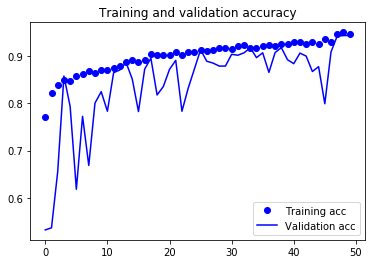

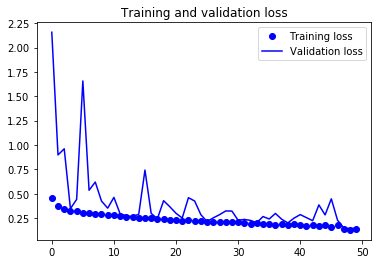

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
#Baseline CNN
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1604/1604 [==============================] - 1s 455us/step
Test loss: 0.176434441175
Test accuracy: 0.93578553616


In [19]:
#FCN

model = create_model()

model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 75, 75, 3)         0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 77, 77, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 64)        18496     
__________

### Predict

In [37]:
_, X_test_b, X_test_images = create_dataset(test, False)
#X_test_images = augment(X_test_images)

Denoising and reshaping
RGB done


In [39]:
predicted_test=gmodel.predict_proba(X_test_images)
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('Baseline2_CNN.csv', index=False)

8424/8424 [==============================] - 4s 423us/step


In [40]:
model = create_model()

predicted_test=model.predict_proba(X_test_images)
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('FCN.csv', index=False)

8424/8424 [==============================] - 3s 335us/step


In [1]:
import tensorflow as tf
sess = tf.Session()
sess.close()
sess._closed
sess._opened

KeyboardInterrupt: 